In [1]:
# import modules
import numpy as np
from sklearn.datasets import load_digits
import scipy
from abc import abstractmethod
from math import log, e

# Base Classes

In [2]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally
          prediction
    '''
        

class Tree:
    '''
      base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min 
    
    def predict(self, x):
        ''' return the prediction for the given 1-D feature vector x
        '''
        # first find the leaf containing the 1-D feature vector x
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        # finally, return the leaf's prediction
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D)) # number of features to consider for each split decision
        
        # initialize the root node
        self.root = Node()
        self.root.features  = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None: # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)
    
    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature 
                         indices to be considered for the present split
                         
        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None, None
        
        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far 
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None: # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        # (store children and split condition)
        node.left = left
        node.right = right
        node.split_index = j_min
        node.threshold = t_min # your code here
        

        # return the children (to be placed on the stack)
        return left, right
    
    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        return np.random.choice(D, size=D_try, replace=False) # your code here
        
    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        # sort the feature values along feature j
        sorted_features = np.sort(node.features[:, j])

        # find the candidate thresholds (in the middle between adjacent feature values)
        thresholds = (sorted_features[:-1] + sorted_features[1:]) / 2

        return thresholds # your code here
       
               
    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t
        
            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()

        # your code here
        # split the data according to the threshold t
        left_mask = node.features[:, j] <= t
        right_mask = node.features[:, j] > t

        # assign the instances to the children
        left.features = node.features[left_mask]
        left.responses = node.responses[left_mask]
        right.features = node.features[right_mask]
        right.responses = node.responses[right_mask]

        return left, right 
        
        
    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")
        
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")


<div style="color: green; font-weight:
bold"> slightly different from solution, especially different threshhold chosen </div>

# Regression Tree

In [3]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        
        # your code here
        #compute loss
        left_mask = node.features[:, j] <= t
        right_mask = node.features[:, j] > t

        # check if the split is admissible
        if np.sum(left_mask) < self.n_min or np.sum(right_mask) < self.n_min:
            return float('inf')

        # compute the loss for the split
        left_responses = node.responses[left_mask]
        right_responses = node.responses[right_mask]

        # squared loss for regression
        left_loss = np.mean((left_responses - np.mean(left_responses)) ** 2)
        right_loss = np.mean((right_responses - np.mean(right_responses)) ** 2)
        loss = left_loss + right_loss

        return loss
       
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a regression tree is a real number)
        node.prediction =  np.mean(node.responses) # your code here
        

<div style="color: green; font-weight:
bold"> different from solution also works </div>

# Classification Tree

In [4]:
class ClassificationTree(Tree):
    '''implement classification tree so that it can handle arbitrary many classes
    '''
    
    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes
        self.criterion = 'entropy' # or 'gini'
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        # your code here
        left_mask = node.features[:, j] <= t
        right_mask = node.features[:, j] > t

        # check if the split is admissible
        if np.sum(left_mask) < self.n_min or np.sum(right_mask) < self.n_min:
            return float('inf')

        # compute the loss for the split
        left_responses = node.responses[left_mask]
        right_responses = node.responses[right_mask]

        left_p = np.mean(left_responses == 1)
        right_p = np.mean(right_responses == 1)
        left_loss = self.entropy(left_p) if self.criterion == 'entropy' else self.gini_impurity(left_p)
        right_loss = self.entropy(right_p) if self.criterion == 'entropy' else self.gini_impurity(right_p)
        loss = (np.sum(left_mask) * left_loss + np.sum(right_mask) * right_loss) / node.features.shape[0]

        return loss
        
    def entropy(self, p):
        ''' compute the entropy
        '''
        value,counts = np.unique(p, return_counts=True)
        norm_counts = counts / counts.sum()
        base = e
        return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()
    
    def gini_impurity(self, p):
        ''' compute the Gini impurity
        '''
        return 1 - p ** 2 - (1 - p) ** 2
        
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a classification tree is a class label)
        # your code here
        #considering the case where there are more than 2 classes class labels as well, the minlengh of bin
        counts_bins = np.bincount(node.responses, minlength=max(self.classes) + 1)
        # print(counts_bins)
        pred_counts = counts_bins[self.classes]  #only select indices that are in self.classes (others are zero)
        # print(np.argmax(pred_counts), pred_counts)
        node.prediction = self.classes[np.argmax(pred_counts)]
        

<div style="color: green; font-weight:
bold"> different from solution also works </div>

# Evaluation of Regression and Classification Tree

In [5]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

(1797, 64) (1797,)


In [6]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionTree()
# and comment on your results
# your code here
from sklearn.model_selection import KFold

def cross_validation(model, features, responses, n_splits=5, regression = False):
    kf = KFold(n_splits=n_splits)
    scores = []
    for train_index, test_index in kf.split(features):
        model.train(features[train_index], responses[train_index])
        preds = np.array([model.predict(features[t]) for t in test_index])
        if regression:
            #for regression we calculate MSE
            scores.append(np.sum((preds - responses[test_index]) ** 2) / len(responses[test_index]))
        else:
            #calculate accuracy from preds and responses for classification
            scores.append(np.sum((preds == responses[test_index]))/len(responses[test_index]))
    # print(scores)
    return np.mean(scores)

print("The mean MSE score for RegressionTree on cross validation is: ", cross_validation(RegressionTree(n_min=5), features, responses, regression=True))

The mean MSE score for RegressionTree on cross validation is:  0.4131528957727181


<div style="color: green; font-weight:
bold"> MSE in solution is smaller and more detailed </div>

In [7]:
# perform 5-fold cross-validation with labels 3 and 9
# using ClassificationTree(classes=np.unique(labels))
# and comment on your results
# your code here
# print(np.unique(labels))
print("The mean accuracy score for ClassificationTree on cross validation is: ",cross_validation(ClassificationTree(classes=np.unique(labels)), features, labels))

The mean accuracy score for ClassificationTree on cross validation is:  0.7798325722983257


<div style="color: green; font-weight:
bold"> MSE in solution is much smaller and more detailed </div>

# Regression and Classification Forest

In [8]:
def bootstrap_sampling(features, responses, split_by_response=None):
    '''return a bootstrap sample of features and responses
    '''

    if split_by_response is None:
        # determine the number of data points
        num_data_points = len(features)

        # generate a set of random indices with replacement
        bootstrap_indices = np.random.choice(range(num_data_points), size=num_data_points, replace=True)

        # use these indices to create a bootstrap sample of the original dataset
        bootstrap_features = features[bootstrap_indices]
        bootstrap_responses = responses[bootstrap_indices]
    else:
        # split the data set based on the supplied response
        features_target = features[responses == split_by_response]
        responses_target = responses[responses == split_by_response]

        features_off_target = features[responses != split_by_response]
        responses_off_target = responses[responses != split_by_response]

        # determine the number of data points
        num_target_points = len(features_target)
        num_off_target_points = len(features_off_target)
        
        # generate a set of random indices with replacement
        bootstrap_indices_target = np.random.choice(range(num_target_points), size=num_target_points, replace=True)
        bootstrap_indices_off_target = np.random.choice(range(num_off_target_points), size=num_target_points, replace=True)
        
        # use these indices to create a bootstrap sample of the original dataset
        bootstrap_features = np.concatenate((features_target[bootstrap_indices_target], features_off_target[bootstrap_indices_off_target]))
        bootstrap_responses = np.concatenate((responses_target[bootstrap_indices_target], responses_off_target[bootstrap_indices_off_target]))
        bootstrap_responses = np.array([1 if r == split_by_response else -1 for r in bootstrap_responses])

    return bootstrap_features, bootstrap_responses

<div style="color: green; font-weight:
bold"> solution much shorter</div>

In [9]:
class RegressionForest():
    def __init__(self, n_trees, n_min=10):
        # create ensemble
        self.trees = [RegressionTree(n_min) for i in range(n_trees)]
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        ... # your code here
        predictions = [tree.predict(x) for tree in self.trees]

        index_max = -1
        score_max = -1
        for index, score in enumerate(predictions):
            if score > score_max:
                index_max = index
                score_max = score

        if score_max > 0:
            return self.classes[index_max]
        else:
            return "unknown"

<div style="color: green; font-weight:
bold"> solution much shorter </div>

In [10]:
class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=1):
        self.trees = [ClassificationTree(classes, n_min) for i in range(n_trees)]
        self.classes = classes
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        ... # your code here
        predictions = [tree.predict(x) for tree in self.trees]
        return scipy.stats.mode(predictions, axis=None, keepdims=False)[0]

<div style="color: green; font-weight:
bold"> different from solution </div>

# Evaluation of Regression and Decision Forest

In [11]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionForest(n_trees=10)
# and comment on your results
# your code here

cross_val_score = cross_validation(RegressionForest(n_trees=10, n_min=5), features, responses, regression=True)
print("The mean MSE score for RegressionForest on cross validation is: ", cross_val_score)

AttributeError: 'RegressionForest' object has no attribute 'classes'

<div style="color: green; font-weight:
bold"> Failed due to attibute error </div>

In [ ]:
# perform 5-fold cross-validation with labels 3 and 9
# using DecisionForest(n_trees=10, classes=np.unique(labels))
# and comment on your results
# your code here

cross_val_score = cross_validation(ClassificationForest(n_trees=10, classes=np.unique(labels)), features, labels)

print("The mean accuracy score for ClassificationTree on cross validation is: ",cross_val_score)

The mean accuracy score for ClassificationTree on cross validation is:  0.917503805175038


<div style="color: green; font-weight:
bold"> MSE in solution is smaller and more detailed </div>

# Multi-class Classification Forest

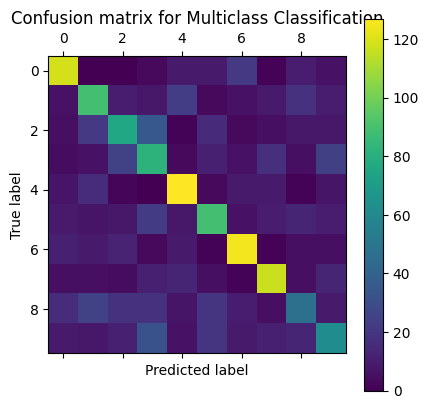

The mean accuracy score for ClassificationTree on cross validation is:  0.5192277932528628


In [ ]:
# Train DecisionForest(n_trees=10, classes=np.unique(digits.target))
# for all 10 digits simultaneously.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
# your code here

#multiclass classification using classification tree
from matplotlib import pyplot as plt

def cross_validation_multiclass(model, features, responses, n_splits=5):
    kf = KFold(n_splits=n_splits)
    scores = []
    confusion_matrix = np.zeros((10,10))
    for train_index, test_index in kf.split(features):
        model.train(features[train_index], responses[train_index])
        preds = np.array([model.predict(features[t]) for t in test_index])
        #calculate accuracy from preds and responses for classification
        scores.append(np.sum((preds == responses[test_index]))/len(responses[test_index]))

        for i in range(len(preds)):
            confusion_matrix[responses[test_index][i]][preds[i]] += 1

    #plot confusion matrix
    plt.matshow(confusion_matrix)
    #plot the title 
    plt.title('Confusion matrix for Multiclass Classification')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()
    plt.show()

    # print(scores)
    return np.mean(scores)

cross_val_score = cross_validation_multiclass(ClassificationTree(classes=np.unique(digits.target)), digits.data, digits.target)
print("The mean accuracy score for ClassificationTree on cross validation is: ",cross_val_score)


#multiclass classification using classification forest

# cross_val_score = cross_validation_multiclass(ClassificationForest(n_trees=10, classes=np.unique(digits.target)), digits.data, digits.target)
# print("The mean accuracy score for ClassificationForest on cross validation is: ",cross_val_score)



### Comments on Result:
As seen above, the multiclass classifier with ClassificationTree performs poorly than binary classifier with same model, this is because there are 10 classes vs 2 in previous case, secondly the multiclass model has to predict 10 classes vs 2 in previous case so the possibly of predicting exactly the correct class wrong is much higher. This can be correct by using soft response instead of hard response, where the model predicts the predicted class based on posterior probability of each class.

For multiclass classificationForest model, it is an ensemble of 10 multi-class classification trees, so the performance is better than single multi-class classification tree. This is to reduce overfitting and increase the accuracy of the model. The accuracy of the model can be further improved by using soft voting instead of hard voting of single trees used in classificationForest.

<div style="color: green; font-weight:
bold"> solultion has values we only plot </div>

# One-against-the-rest classification with RegressionForest

In [ ]:
%%timeit -n 1 -r 1
import seaborn

# Train ten one-against-the-rest regression forests for the 10 digits.
# Make sure that all training sets are balanced between the current digit and the rest.
# Assign test instances to the digit with highest score, 
# or to "unknown" if all scores are negative.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
features = digits.data
labels = digits.target

splitter = KFold(n_splits=5)
classes = list(np.unique(labels))
classes.append("unknown")

forest = RegressionForest()
confusion_matrix = np.zeros((len(classes), len(classes)))

for train_index, test_index in splitter.split(features):
    forest.train(features[train_index], labels[train_index])

    for sample in test_index:
        label = labels[sample]
        prediction = forest.predict(features[sample])
        confusion_matrix[classes.index(label)][classes.index(prediction)] += 1

print("Accuracy: {:.1%}".format(np.trace(confusion_matrix) / np.sum(confusion_matrix)))

plt.figure(figsize=(10, 8))
seaborn.heatmap(confusion_matrix / np.sum(confusion_matrix, axis=1), annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix after 5-fold cross-validation')
plt.show()

TypeError: RegressionForest.__init__() missing 1 required positional argument: 'n_trees'

<div style="color: green; font-weight:
bold"> produces error doesn't work </div>